# 1. Генерация данных

In [ ]:
import pandas as pd
import numpy as np

from sklearn.datasets import make_classification

In [ ]:
x_data_generated, y_data_generated = make_classification(scale=1, random_state=24)

In [ ]:
x_data_generated.shape

(100, 20)

In [ ]:
y_data_generated

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0])

In [ ]:
df_score = pd.DataFrame(columns=['способ выбора признаков', 'количество признаков', 'признаки', 'средняя точность модели'])

# 2. Модель логистической регрессии

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [ ]:
def get_cross_val_score(x, y):
  cvs = cross_val_score(LogisticRegression(),
                        x, y,
                        scoring='accuracy')

  return cvs.mean()

In [ ]:
score = get_cross_val_score(x_data_generated, y_data_generated)
df_score.loc[len(df_score)] = ['LogisticRegression()', x_data_generated.shape[1], '[0:20]', score]
score

0.8099999999999999

Средняя точность уже получилась достаточно высокой.

# 3. Отбор признаков статистическими методами

## 3.1. Матрица корреляции

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.DataFrame(x_data_generated)
df['y'] = y_data_generated

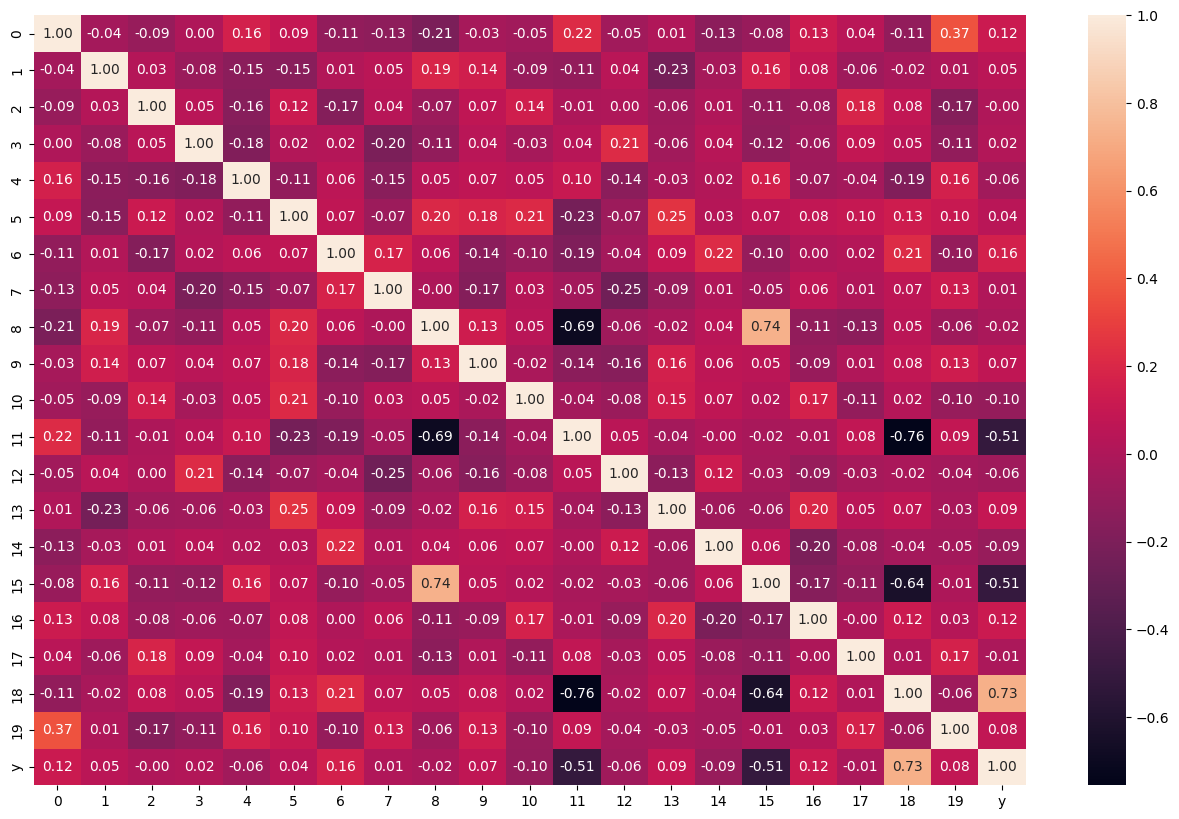

In [ ]:
plt.figure(figsize=(16, 10))
sns.heatmap(df.corr(), annot=True, fmt='.2f')
plt.show()

Сначала можно оставить признаки с коэффициентом корреляции > 0.5 (по модулю). Это колонки 11, 15 и 18:

In [ ]:
x_new = [11, 15, 18]
score = get_cross_val_score(df[x_new], y_data_generated)
df_score.loc[len(df_score)] = ['Correlation matrix', len(x_new), x_new, score]
score

0.86

Признаки с коэффициентом корреляции > 0.1 (колонки 0, 6, 11, 15, 16 и 18):

In [ ]:
x_new = [0, 6, 11, 15, 16, 18]
score = get_cross_val_score(df[x_new], y_data_generated)
df_score.loc[len(df_score)] = ['Correlation matrix', len(x_new), x_new, score]
score

0.8400000000000001

При удалении колонок с низким коэффициентом корреляции (до 0.1 включительно) средняя точность = 0.84.

Для порогового значения коэффициента корреляции, равного 0.5, средняя точность = 0.86.

## 3.2. Отсечение низковариативных признаков с последующим построением модели логистической регрессии

In [ ]:
from sklearn.feature_selection import VarianceThreshold
import statistics

In [ ]:
variances = [statistics.pvariance(x) for x in x_data_generated]
thresholds = {'mean': np.mean(variances),
             'max': max(variances),
             'moda': np.quantile(variances, .5),
             '0.5': .5,
             '1': 1,
             '1.5': 1.5,
             '2': 2}

In [ ]:
for key, value in thresholds.items():
  vt = VarianceThreshold(threshold=value)
  x_new = vt.fit_transform(x_data_generated)
  cvs = get_cross_val_score(x_new, y_data_generated)

  df_score.loc[len(df_score)] = [f'VarianceThreshold (threshold = {round(value, 3)})',
                                 f'{x_new.shape[1]}',
                                 f"{'[0:20]' if len(vt.get_support(indices=True)) == 20 else vt.get_support(indices=True)}",
                                 cvs]

  print(f'threshold = {round(value, 3)} ({key})\n{x_new.shape[1]} columns {vt.get_support(indices=True)} \nscore = {cvs}\n')

threshold = 1.177 (mean)
4 columns [ 8 11 15 18] 
score = 0.85

threshold = 2.623 (max)
1 columns [15] 
score = 0.7

threshold = 1.151 (moda)
5 columns [ 3  8 11 15 18] 
score = 0.8300000000000001

threshold = 0.5 (0.5)
20 columns [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] 
score = 0.8099999999999999

threshold = 1 (1)
13 columns [ 0  1  2  3  4  8  9 10 11 13 15 16 18] 
score = 0.8300000000000001

threshold = 1.5 (1.5)
3 columns [ 8 11 15] 
score = 0.86

threshold = 2 (2)
2 columns [11 15] 
score = 0.85



В случае отсечения низковариативных признаков с помощью VarianceThreshold лучший результат получился при указании дисперсии, равной 1.5. Средняя точность = 0.86, всего использовалось 3 признака.

Результат совпадает с моделью, построенной на отобранных с помощью матрицы корреляции данных (у которых коэффициентом корреляции по модулю больше 0.5).

Для 1 признака, например, результат получился значительно хуже, средняя точность = 0.7.


# 4. Отбор признаков на основе дисперсионного анализа

In [ ]:
from sklearn.feature_selection import f_classif, SelectKBest

In [ ]:
def get_x_new(model, x, y, df_score, method_info):
  x_new = model.fit_transform(x, y)
  columns = model.get_support(indices=True)
  score = get_cross_val_score(x_new, y)

  print(f'{x_new.shape[1]} columns {columns}')
  print(f'score = {score}\n')

  df_score.loc[len(df_score)] = [method_info, x_new.shape[1], columns, score]

In [ ]:
n_features = [3, 5, 7]

for n in n_features:
  get_x_new(
      SelectKBest(score_func=f_classif, k=n),
      x_data_generated,
      y_data_generated,
      df_score,
      'SelectKBest()')

3 columns [11 15 18]
score = 0.86

5 columns [ 6 11 15 16 18]
score = 0.85

7 columns [ 0  6 10 11 15 16 18]
score = 0.8799999999999999



Для 5 лучших признаков средняя точность получилась немного меньше чем у VarianceThreshold (0.85).

А вот для 7 признаков средняя точность уже больше (0.88).

# 5. Отбор признаков с использованием моделей

## 5.1. Логистическая регрессия

In [ ]:
from sklearn.feature_selection import SelectFromModel

L1:

In [ ]:
n_features = [3, 5, 7]

for n in n_features:
  sfm = SelectFromModel(
      estimator=LogisticRegression(penalty='l1', solver='liblinear', random_state=24),
      max_features=n)

  get_x_new(
      sfm,
      x_data_generated,
      y_data_generated,
      df_score,
      'SelectFromModel(LogisticRegression(L1))')

3 columns [ 0  1 18]
score = 0.8799999999999999

5 columns [ 0  1 10 17 18]
score = 0.8799999999999999

7 columns [ 0  1  5 10 17 18 19]
score = 0.86



L2:

In [ ]:
sfm = SelectFromModel(
    estimator=LogisticRegression(penalty='l2', random_state=24),
    max_features=6)

get_x_new(
    sfm,
    x_data_generated,
    y_data_generated,
    df_score,
    'SelectFromModel(LogisticRegression(L2))')

6 columns [ 0  1 11 15 17 18]
score = 0.89



При указании L1 регуляризаци средняя точность для 3 и 5 признаков = 0.88, для 7 признаков = 0.86.

А, например, для L2 и 6 признаков - 0.89.

## 5.2. RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model = RandomForestClassifier(random_state=24)
model.fit(x_data_generated, y_data_generated)

RandomForestClassifier(random_state=24)

<Axes: >

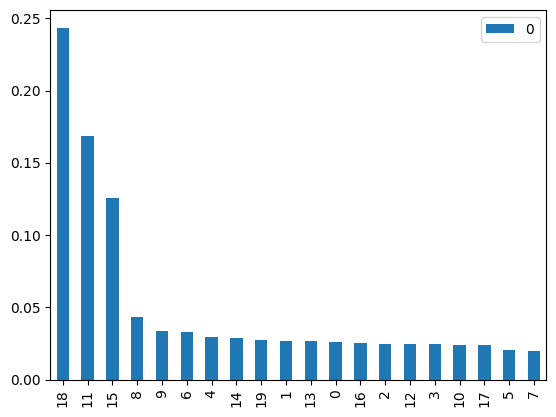

In [ ]:
pd.DataFrame(model.feature_importances_).sort_values(0, ascending=False).plot.bar()

In [ ]:
n_features = [3, 4]

for n in n_features:
  sfm = SelectFromModel(estimator=model, max_features=n, threshold=-np.inf)

  get_x_new(
      sfm,
      x_data_generated,
      y_data_generated,
      df_score,
      'SelectFromModel(RandomForest)')

3 columns [11 15 18]
score = 0.86

4 columns [ 8 11 15 18]
score = 0.85



# 6. Перебор признаков

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

RandomForestClassifier:

In [ ]:
n_features = [3, 5, 7]

for n in n_features:
  sfs_forward = SequentialFeatureSelector(
    estimator=model,
    n_features_to_select=n,
    direction='forward')

  get_x_new(
      sfs_forward,
      x_data_generated,
      y_data_generated,
      df_score,
      'SequentialFeatureSelector(RandomForest, forward)')

3 columns [11 15 18]
score = 0.86

5 columns [ 1  4 11 15 18]
score = 0.8700000000000001

7 columns [ 1  2  4 10 11 15 18]
score = 0.86



In [ ]:
n_features = [3, 5, 7]

for n in n_features:
  sfs_forward = SequentialFeatureSelector(
    estimator=model,
    n_features_to_select=n,
    direction='backward')

  get_x_new(
      sfs_forward,
      x_data_generated,
      y_data_generated,
      df_score,
      'SequentialFeatureSelector(RandomForest, backward)')

3 columns [ 2 11 15]
score = 0.86

5 columns [ 2 11 12 15 19]
score = 0.8300000000000001

7 columns [ 2 10 11 12 14 15 19]
score = 0.8300000000000001



LogisticRegression:

In [ ]:
n_features = [3, 5, 7]

for n in n_features:
  sfs_forward = SequentialFeatureSelector(
    estimator=LogisticRegression(penalty='l1', solver='liblinear', random_state=24),
    n_features_to_select=n,
    direction='forward')

  get_x_new(
      sfs_forward,
      x_data_generated,
      y_data_generated,
      df_score,
      'SequentialFeatureSelector(LR, forward)')

3 columns [ 1  2 18]
score = 0.8799999999999999

5 columns [ 1  2  4  5 18]
score = 0.8699999999999999

7 columns [ 1  2  4  5  6  7 18]
score = 0.8800000000000001



In [ ]:
n_features = [3, 5, 7]

for n in n_features:
  sfs_forward = SequentialFeatureSelector(
    estimator=LogisticRegression(penalty='l1', solver='liblinear', random_state=24),
    n_features_to_select=n,
    direction='backward')

  get_x_new(
      sfs_forward,
      x_data_generated,
      y_data_generated,
      df_score,
      'SequentialFeatureSelector(LR, backward)')

3 columns [10 14 18]
score = 0.8799999999999999

5 columns [10 14 16 17 18]
score = 0.8699999999999999

7 columns [10 12 13 14 16 17 18]
score = 0.8699999999999999



SequentialFeatureSelector для RandomForestClassifier дает результаты немного хуже чем для LogisticRegression, плюс требует значительно больше времени на обучение, особенно в случае backward.

Лучший результат средней точности модели здесь у LogisticRegression c L1 регуляризацией, 7 признаками и направлением forward (0.88).  

# 7. Выводы

In [ ]:
df_score

,способ выбора признаков,количество признаков,признаки,средняя точность модели
0,LogisticRegression(),20,[0:20],0.81
1,Correlation matrix,3,"[11, 15, 18]",0.86
2,Correlation matrix,6,"[0, 6, 11, 15, 16, 18]",0.84
3,VarianceThreshold (threshold = 1.177),4,[ 8 11 15 18],0.85
4,VarianceThreshold (threshold = 2.623),1,[15],0.70
5,VarianceThreshold (threshold = 1.151),5,[ 3 8 11 15 18],0.83
6,VarianceThreshold (threshold = 0.5),20,[0:20],0.81
7,VarianceThreshold (threshold = 1),13,[ 0 1 2 3 4 8 9 10 11 13 15 16 18],0.83
8,VarianceThreshold (threshold = 1.5),3,[ 8 11 15],0.86
9,VarianceThreshold (threshold = 2),2,[11 15],0.85


In [ ]:
df_score.sort_values(['средняя точность модели', 'количество признаков'], ascending=[False, True]).head(10)

,способ выбора признаков,количество признаков,признаки,средняя точность модели
16,SelectFromModel(LogisticRegression(L2)),6,"[0, 1, 11, 15, 17, 18]",0.89
27,"SequentialFeatureSelector(LR, forward)",7,"[1, 2, 4, 5, 6, 7, 18]",0.88
13,SelectFromModel(LogisticRegression(L1)),3,"[0, 1, 18]",0.88
25,"SequentialFeatureSelector(LR, forward)",3,"[1, 2, 18]",0.88
28,"SequentialFeatureSelector(LR, backward)",3,"[10, 14, 18]",0.88
14,SelectFromModel(LogisticRegression(L1)),5,"[0, 1, 10, 17, 18]",0.88
12,SelectKBest(),7,"[0, 6, 10, 11, 15, 16, 18]",0.88
20,"SequentialFeatureSelector(RandomForest, forward)",5,"[1, 4, 11, 15, 18]",0.87
26,"SequentialFeatureSelector(LR, forward)",5,"[1, 2, 4, 5, 18]",0.87
29,"SequentialFeatureSelector(LR, backward)",5,"[10, 14, 16, 17, 18]",0.87


Лучше всех справился с отбором признаков **SelectFromModel** для LogisticRegression c L2 регуляризацией и 6 признаками. Средняя точность модели = **0.89**.

**SequentialFeatureSelector** для LogisticRegression c L1 регуляризацией, 7 признаками и направлением forward показал среднюю точность, равную **0.88** (немного больше - 0.8800000000000001).

Средную точность, равную **0.88** (немного меньше - 0.8799999999999999), для 3 признаков показали следующие способы:
- **SelectFromModel** для LogisticRegression c L1 регуляризацией
- **SequentialFeatureSelector** для LogisticRegression c L1 регуляризацией и направлением forward
- **SequentialFeatureSelector** для LogisticRegression c L1 регуляризацией и направлением backward